# Data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:

X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

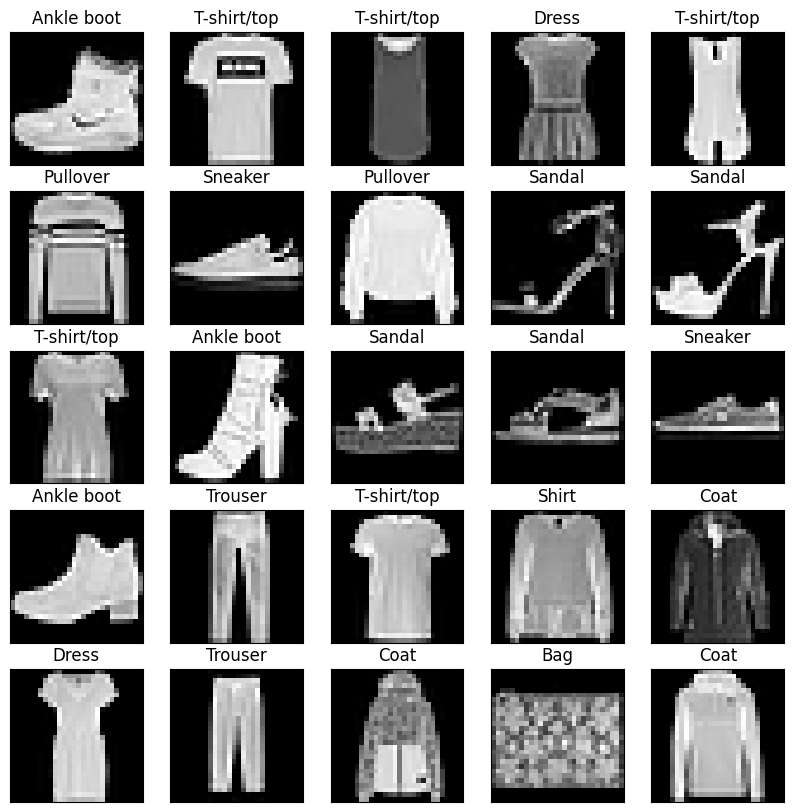

In [5]:
# Classes of Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot some sample images (need to reshape each sample back to 28x28 for visualization)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')  # Reshape for plotting
    plt.title(class_names[y_train[i]])
plt.show()

# Preprocessing data

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
Xmean = X_train.mean(axis=0)
X_train_normalized = X_train - Xmean
X_test_normalized = X_test - Xmean

# Training and Evaluation

vì Linear kernel không hỗ trợ với dữ liệu từ cupy để train trên GPU nên ta dùng dữ liệu bth để train 

In [ ]:
time_start = time.time()
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_normalized, y_train)
time_end = time.time()
print("Training time of Linear SVM: ", time_end - time_start, "seconds")

In [63]:
y_pred_train = lin_clf.predict(X_train_normalized)
accuracy_score(y_train, y_pred_train)

0.87365

In [64]:
y_pred_test = lin_clf.predict(X_test_normalized)
accuracy_score(y_test, y_pred_test)

0.8401

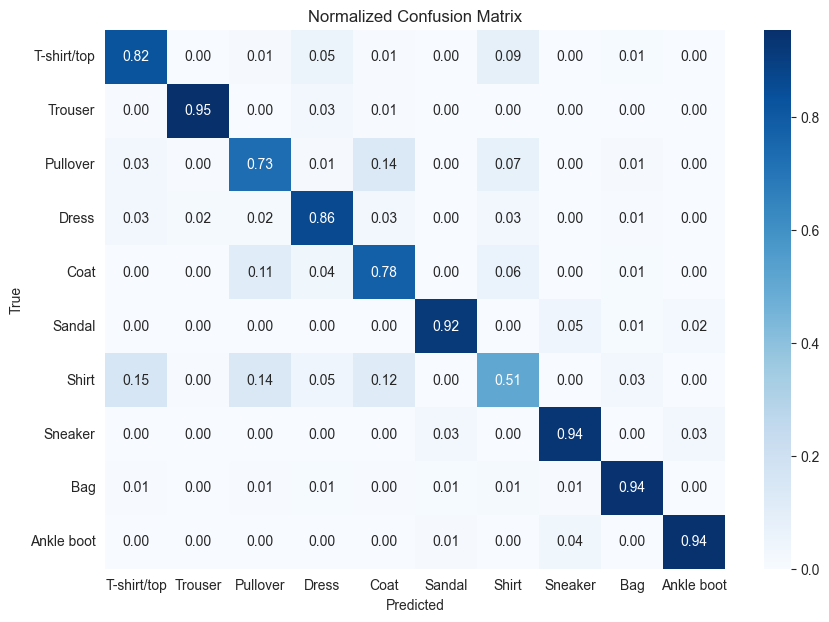

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Normalize Confusion Matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

Khi train trên SVM linear thì tốn khá nhiều thời gian để train nên ta sẽ quyết định train 10k ảnh để rút ngắn thời gian training, nhưng vẫn cần đảm bảo dữ liệu có nhãn balance khi lấy sample, hướng tiếp cận này là **two-stage training**

In [75]:
num_class = 10
sample_per_class = 1000

X_balance = []
y_balance = []

for i in range(num_class):
    class_indices = np.where(y_train == i)[0]
    chosen_indices = np.random.choice(class_indices, sample_per_class, replace=False)

    X_balance.append(X_train_normalized[chosen_indices])
    y_balance.append(y_train[chosen_indices])

X_small = np.vstack(X_balance)
y_small = np.hstack(y_balance)


In [77]:
time_start = time.time()
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_small, y_small)
time_end = time.time()
print("Training time of SVM with RBF kernel: ", time_end - time_start, "seconds")

Training time of SVM with RBF kernel:  9.468922853469849 seconds


In [82]:
y_pred = svm_clf.predict(X_small)
print("Accuracy on small training set: ", accuracy_score(y_small, y_pred))

Accuracy on small training set:  0.9151


Sau khi train thử với bộ dữ liệu nhỏ hơn 6 lần bộ dữ liệu ban đầu thì kết quả cho ra cũng đã cao hơn 0.87365 của SVM linear khi được train trên tập dữ liệu gốc

Chúng ta tiếp tục tinh chỉnh siêu tham số cho model SVM cụ thể ở đây là parameter C để tìm được giá trị C tối ưu cho model

In [85]:
import warnings
warnings.filterwarnings("ignore")

X_small_df = pd.DataFrame(X_small)
y_small_df = pd.DataFrame(y_small)

Cs = np.logspace(-2, 3, num=10)
MCV_list = []

for C in Cs:
    current_svm = SVC(kernel='rbf', C=C)
    kf = KFold(n_splits=3, random_state=1, shuffle=True)
        
    mean_crossval = np.mean(cross_val_score(current_svm, X_small_df, y_small_df, cv=kf))
    MCV_list.append(mean_crossval)
    print("On C=", C, "\tMCV=", mean_crossval)
    


On C= 0.01 	MCV= 0.6910004137786304
On C= 0.03593813663804628 	MCV= 0.7511008449375232
On C= 0.1291549665014884 	MCV= 0.799400995888431
On C= 0.464158883361278 	MCV= 0.8383006267033423
On C= 1.6681005372000592 	MCV= 0.8644004172462837
On C= 5.994842503189409 	MCV= 0.8740003574442627
On C= 21.544346900318846 	MCV= 0.8692002373602689
On C= 77.42636826811278 	MCV= 0.8692004173422742
On C= 278.2559402207126 	MCV= 0.8692004173422742
On C= 1000.0 	MCV= 0.8692004173422742


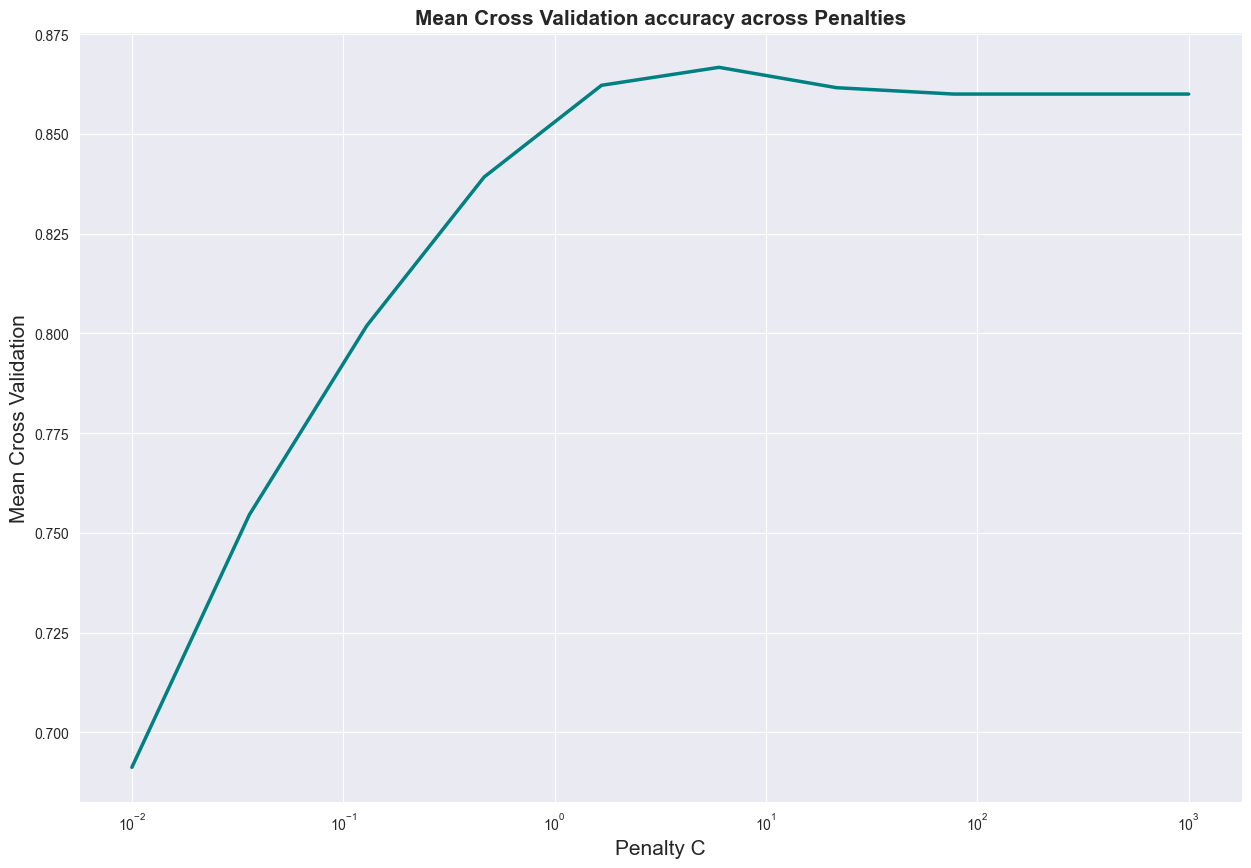

In [16]:
# Set plot specifications
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,10))
lw = 2.5

plt.plot(Cs, MCV_list, color= 'teal', linewidth = lw)
plt.title("Mean Cross Validation accuracy across Penalties" ,fontsize=15, fontweight="bold")
plt.xlabel('Penalty C', fontsize = 15)
plt.xscale("log")
plt.ylabel('Mean Cross Validation', fontsize = 15)
plt.show()

Sau đó ta tiến hành train trên toàn bộ tập dữ liệu sau khi tìm ra được tham số C tối ưu cho tập dữ liệu nhỏ

chọn C=1.6681005372000592 chứ không chọn C=5.994842503189409, vì rất có thể tại điểm này thì Mean cross validation score đã giảm nên có thể gây ra overfitting 

In [ ]:
time_start = time.time()
optimal_C= 1.6681005372000592
final_svm = SVC(kernel='rbf', C=optimal_C)
final_svm.fit(X_train_normalized, y_train_normalized)
time_end = time.time()

y_pred = final_svm.predict(X_test_normalized)
train_accuracy = final_svm.score(X_train_normalized, y_train_normalized)
test_accuracy = final_svm.score(X_test_normalized, y_test_normalized)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)
print("Training time of SVM with RBF kernel on full dataset: ", time_end - time_start, "seconds")

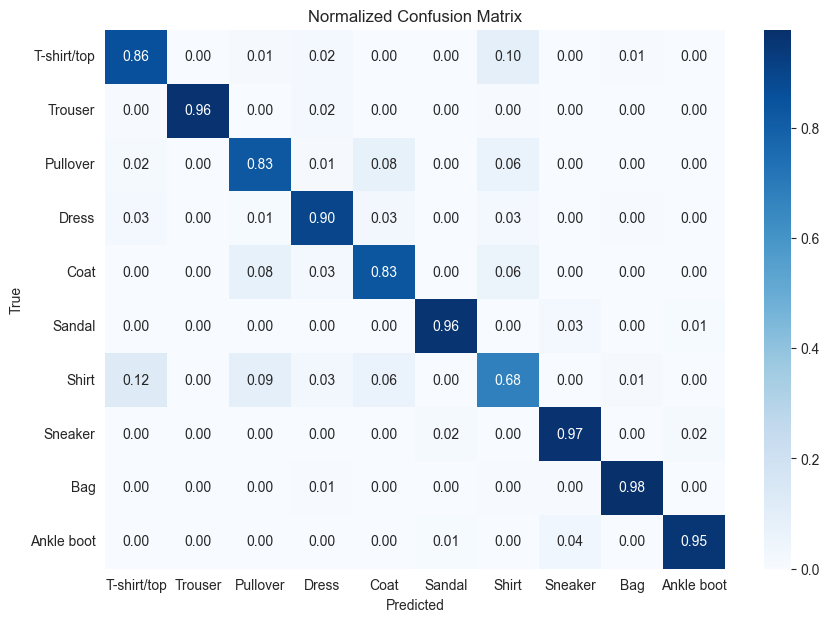

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize Confusion Matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Dimension reduce by using PCA and Evaluate of reduce models

In [19]:
def pca_reduction(X_train, X_test, target_dim):
    if target_dim:
        pca = PCA(n_components=target_dim, random_state=42)
    else:
        pca = PCA(random_state=42)
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test = pca.transform(X_test)
    return pca_train, pca_test

def lda_reduction(X_train, y_train, X_test, component_number=None):
    lda = LDA(n_components=component_number)
    lda.fit(X_train, y_train)
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda
    

In [20]:
X_train_pca, X_test_pca = pca_reduction(X_train_normalized, X_test_normalized, target_dim=100)
X_train_lda, X_test_lda = lda_reduction(X_train_normalized, y_train, X_test_normalized, component_number=9)

Text(0.5, 1.0, 'Decision surface of Support Vector Machine')

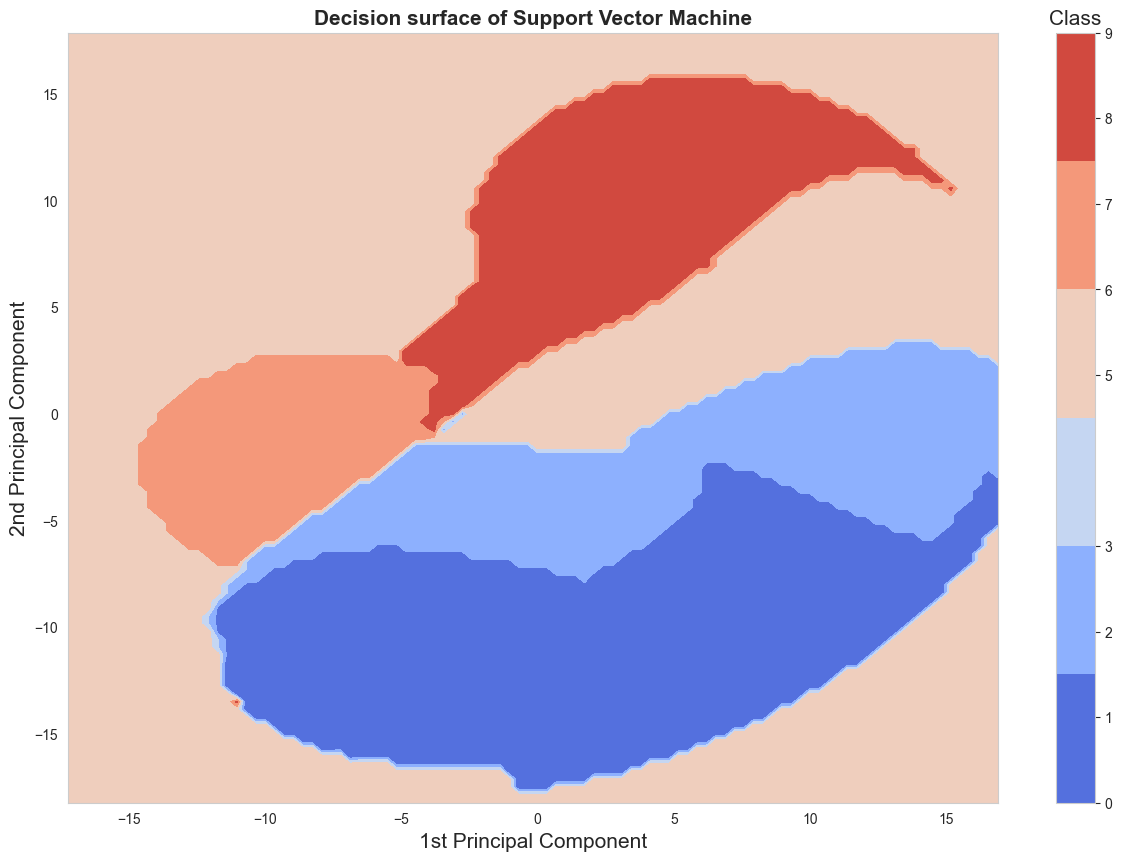

In [25]:
pca = PCA(n_components=2)

Z = pca.fit_transform(X_train_normalized)

V = pca.components_

Z_x = Z[0]
Z_y = Z[1]

std_x = np.std(Z_x)
std_y = np.std(Z_y)

x_min, x_max = -5*std_x, 5*std_x
y_min, y_max = -5*std_y, 5*std_y
x_step = std_x/10
y_step = std_y/10

xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step), np.arange(y_min, y_max, y_step))

z = np.c_[xx.ravel(), yy.ravel()]

# Revert projection
x = np.dot(z,V)

predictions = final_svm.predict(x)
predictions = predictions.reshape(xx.shape)

# Plot decision boundaries
sns.set_style("whitegrid")
plt.figure(figsize = (15,10))
contour = plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm)
clb = plt.colorbar(contour, boundaries=list(np.unique(predictions)),
                        ticks=list(np.unique(predictions)),spacing='proportional')
clb.ax.set_title('Class', fontsize=15)
plt.xlabel('1st Principal Component', fontsize = 15)
plt.ylabel('2nd Principal Component', fontsize = 15)
plt.title("Decision surface of Support Vector Machine", fontweight = 'bold', fontsize=15)